In [ ]:
import json
import logging
import sys

import nest_asyncio
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

from TiktokAPI import TiktokAPI

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
nest_asyncio.apply()

with open("../config.json") as f:
  tikapi = TiktokAPI(json.loads(f.read())["Tiktok"])

In [ ]:
keywords = [
    "chemical spill ohio",
    "Derail",
    "Derailment",
    "ohio polyvinyl chloride",
    "ohio train wreck water",
    "ohio water test",
    "OhioTrainCrash",
    "Ohiotrainderailed",
    "Ohiouncuredpvc",
    "VinylChloride",
]

### 1. Query Tiktok video data by keyword

In [ ]:
for query in keywords:
    result = tikapi.query(query)
    with open(f"../data/tiktok/query_result/{query}.json", "w") as f:
        f.write(json.dumps(result))

### 2. Time series analysis

In [7]:
dfs = list()
for keyword in keywords:
    videos = list()
    with open(f"../data/tiktok/query_result/{keyword}.json", "r") as f:
        for content in json.loads(f.read()):
            try:
                videos.extend(content["item_list"])
            except Exception:
                continue
    df_keyword = tikapi.prase_video_result(videos)
    df_keyword["Keyword"] = keyword
    dfs.append(df_keyword)
df_videos = pd.concat(dfs)
df_videos = df_videos[(df_videos["Date"] >= "20230203") & (df_videos["Date"] <= "20230228")].dropna(subset=["CreateTime"])
df_videos = df_videos[df_videos["Title"].str.lower().str.contains("derail", regex=True)]
df_videos = df_videos[~df_videos.index.duplicated(keep="first")]

<AxesSubplot: xlabel='Date'>

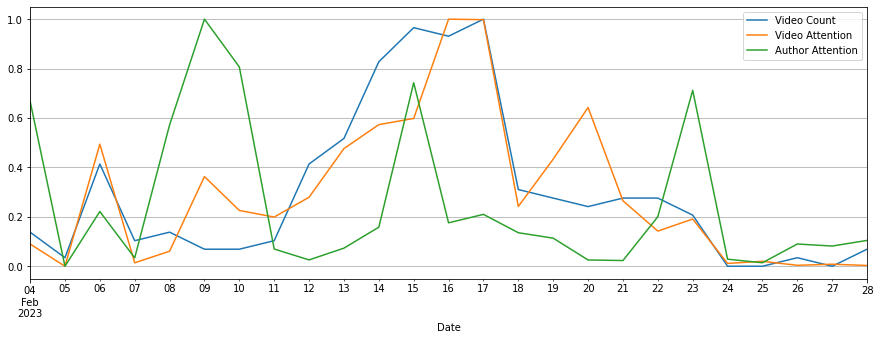

In [8]:
def builf_features(df_videos: pd.DataFrame) -> pd.DataFrame:
    date_index = pd.DatetimeIndex(df_videos["Date"].drop_duplicates().sort_values())
    df_features = pd.DataFrame(index=date_index)

    video_count = df_videos.groupby(["Date"]).count()["Play"]
    video_play = df_videos.groupby(["Date"]).sum()["Play"]
    video_author = df_videos.groupby(["Date"]).mean()["AuthorFollower"]

    for col, df in [("Video Count", video_count),
                    ("Video Attention", video_play),
                    ("Author Attention", video_author)]:
        df.index = pd.DatetimeIndex(df.index)
        df_features[col] = df

    df_features = df_features.fillna(0)
    return df_features

df_features = builf_features(df_videos)
df_features = pd.DataFrame(MinMaxScaler().fit_transform(df_features), columns=df_features.columns, index=df_features.index)
df_features.plot(grid=True, figsize=(15, 5))

In [ ]:
df_features.to_csv("../data/tiktok/DerailmentFeatures.csv", index_label="Date", sep="\t")

### 3. Nuclear Leak Analysis

In [9]:
videos = list()
with open(f"../data/tiktok/query_result/NuclearLeak.json", "r") as f:
    for content in json.loads(f.read()):
        try:
            videos.extend(content["item_list"])
        except Exception:
            continue
df_videos = tikapi.prase_video_result(videos)
df_videos = df_videos[(df_videos["Date"] >= "20230308") & (df_videos["Date"] <= "20230331")].dropna(subset=["CreateTime"])
df_videos = df_videos[~df_videos.index.duplicated(keep="first")]

<AxesSubplot: >

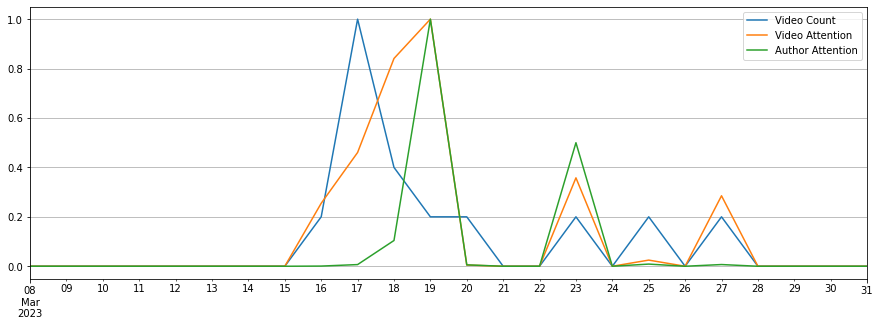

In [22]:
df_features = builf_features(df_videos)
df_features = pd.DataFrame(index=pd.date_range("20230308", "20230331")).merge(df_features, left_index=True, right_index=True, how="left").fillna(0)
df_features = pd.DataFrame(MinMaxScaler().fit_transform(df_features), columns=df_features.columns, index=df_features.index)
df_features.plot(grid=True, figsize=(15, 5))

In [12]:
df_features.to_csv("../data/tiktok/NuclearFeatures.csv", index_label="Date", sep="\t")